# Оценка рисков ДТП по выбранному маршруту движения

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

**Идея решения задачи от заказчика**:
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
  - Для модели выбрать тип виновника — только машина (car).
  - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
  - Для моделирования ограничиться данными за 2012 год — они самые свежие.
  - Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
  - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
  - Какие ещё факторы нужно учесть?
  - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Подключитесь к базе. Загрузите таблицы sql

- Все ли таблицы имеют набор данных;
- Соответствует ли количество таблиц условию задачи;
- Имеется ли общий ключ для связи таблиц.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

Загружаем базу данных:

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения:

In [4]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [5]:
query = '''
SELECT *
FROM collisions
limit 10
'''

sample_collisions = pd.read_sql_query(query, con=engine) 
sample_collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [6]:
query = '''
select *
from case_ids
limit 10
'''
sample_case_ids = pd.read_sql_query(query, con=engine)
sample_case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [7]:
query = '''
SELECT *
FROM vehicles
limit 10
'''

sample_vehicles = pd.read_sql_query(query, con=engine) 
sample_vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [8]:
query = '''
SELECT *
FROM parties
limit 10
'''

sample_parties = pd.read_sql_query(query, con=engine) 
sample_parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


### Вывод

- Все таблицы имеют набор данных;
- Количество таблиц соответствует условию задачи;
- Общий ключ для связи таблиц имеется.

##  Проведите статистический анализ факторов ДТП

Посмотрим в какие месяцы происходит наибольшее количество аварий:

In [9]:
query = '''
select distinct extract(month from collision_date) month_date,
      count(case_id) total_collisions
from collisions
group by month_date
order by total_collisions desc
'''

count_collions = pd.read_sql_query(query, con=engine)
count_collions

,month_date,total_collisions
0,3.0,139581
1,1.0,132044
2,5.0,130316
3,4.0,130180
4,2.0,128858
5,10.0,112237
6,12.0,107945
7,9.0,105159
8,11.0,104770
9,8.0,104089


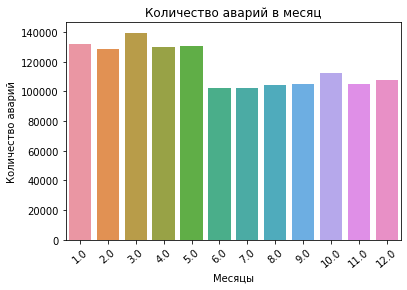

In [10]:
import seaborn as sns
sns.barplot(data = count_collions, x='month_date', y='total_collisions')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

Как очевидно из графика, наибольшее количество аварий приходится на март месяц

Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП:

In [11]:
query = '''
select distinct road_surface,
       count(collision_damage) over (partition by road_surface) count_collision_damage       
from collisions
'''
damage_collisions = pd.read_sql_query(query, con=engine)
damage_collisions

,road_surface,count_collision_damage
0,dry,1242026
1,wet,136236
2,None,13093
3,slippery,1384
4,snowy,7261


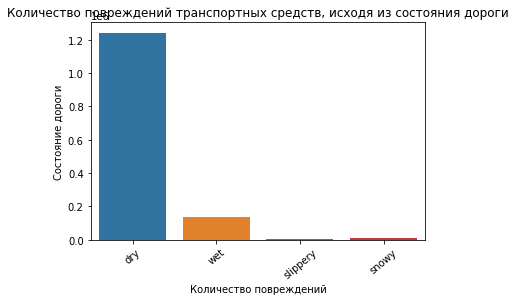

In [12]:
sns.barplot(data = damage_collisions, x='road_surface', y='count_collision_damage')
plt.title('Количество повреждений транспортных средств, исходя из состояния дороги')
plt.xticks(rotation=40)
plt.xlabel('Количество повреждений')
plt.ylabel('Состояние дороги')
plt.show()

Очевидно, что чаще всего дтп происходят когда дорогая сухая,но так же можно увидеть что мокрая дорога может повлиять на вероятность возникновения ДТП

Проведем анализ серьёзности повреждений транспортного средства, исходя из дорожного состояния в момент ДТП:

In [13]:
query = '''
select distinct road_condition_1,
       count(collision_damage) over (partition by road_condition_1) count_road_condition       
from collisions
where road_condition_1 != 'normal'
order by count_road_condition desc
'''
road_condition = pd.read_sql_query(query, con=engine)
road_condition

,road_condition_1,count_road_condition
0,construction,19332
1,other,5688
2,holes,5484
3,obstruction,5276
4,loose material,2887
5,reduced width,1576
6,flooded,1114


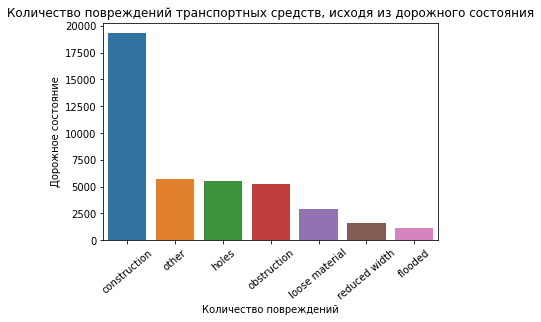

In [14]:
sns.barplot(data = road_condition, x='road_condition_1', y='count_road_condition')
plt.title('Количество повреждений транспортных средств, исходя из дорожного состояния')
plt.xticks(rotation=40)
plt.xlabel('Количество повреждений')
plt.ylabel('Дорожное состояние')
plt.show()

ДТП чаще всего случаются на дорогах без повреждений. Однако, дороги с зоной строительства или ремонта так же увлечивают риск возникновения ДТП

Найдем самые частые причины ДТП (таблица parties):

In [15]:
query = '''
select distinct primary_collision_factor,
       count(primary_collision_factor) count_collision_factor
from collisions
where primary_collision_factor != 'unknown' 
group by primary_collision_factor
order by count_collision_factor desc
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

,primary_collision_factor,count_collision_factor
0,vehicle code violation,1316453
1,other than driver,29780
2,other improper driving,8470
3,fell asleep,117


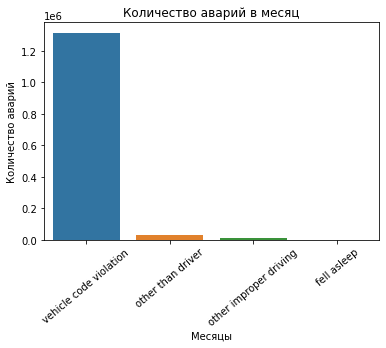

In [16]:
sns.barplot(data = collisions_reasons, x='primary_collision_factor', y='count_collision_factor')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

Бесспорно, самой частой причиной аварий является нарушение пдд

Найдем самые частые нарушения:

In [17]:
query = '''
select distinct pcf_violation_category,
       count(pcf_violation_category) count_pcf_violation_category
from collisions
group by pcf_violation_category
order by count_pcf_violation_category desc
limit 5
'''
violation_category = pd.read_sql_query(query, con=engine)
violation_category 

,pcf_violation_category,count_pcf_violation_category
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962


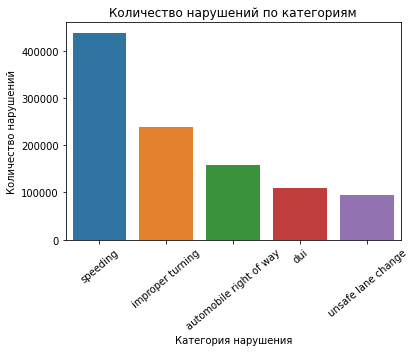

In [18]:
sns.barplot(data = violation_category, x='pcf_violation_category', y='count_pcf_violation_category')
plt.title('Количество нарушений по категориям')
plt.xticks(rotation=40)
plt.xlabel('Категория нарушения')
plt.ylabel('Количество нарушений')
plt.show()

Самыми частыми нарушениями является привышение скорости. На втором месте находится неправильный поворот

Посмотрим влияет ли погода на веротятность ДТП:

In [19]:
query = '''
select distinct weather_1,
       count(case_id) count_collisions
from collisions
group by weather_1
order by count_collisions desc
'''
weather_damage = pd.read_sql_query(query, con=engine)
weather_damage

,weather_1,count_collisions
0,clear,1121048
1,cloudy,203030
2,raining,57976
3,None,7259
4,fog,6156
5,snowing,2571
6,other,1516
7,wind,444


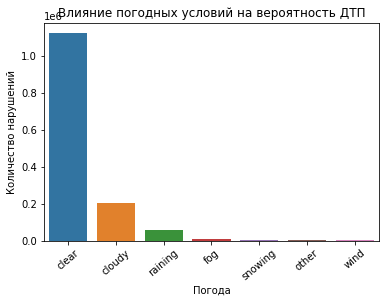

In [20]:
sns.barplot(data = weather_damage, x='weather_1', y='count_collisions')
plt.title('Влияние погодных условий на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Погода')
plt.ylabel('Количество нарушений')
plt.show()

Чаще всего дтп происходят в нормальную погоду, но все же наиболее высокий риск попасть в дтп в облачную погоду или в дождь

Проверим влияет ли освещение на вероятность возникновения ДТП:

In [21]:
query = '''
select distinct lighting,
       count(case_id) count_collisions
from collisions
group by lighting
order by count_collisions desc
'''
lighting_damage = pd.read_sql_query(query, con=engine)
lighting_damage

,lighting,count_collisions
0,daylight,941950
1,dark with street lights,291887
2,dark with no street lights,106170
3,dusk or dawn,47199
4,None,8593
5,dark with street lights not functioning,4201


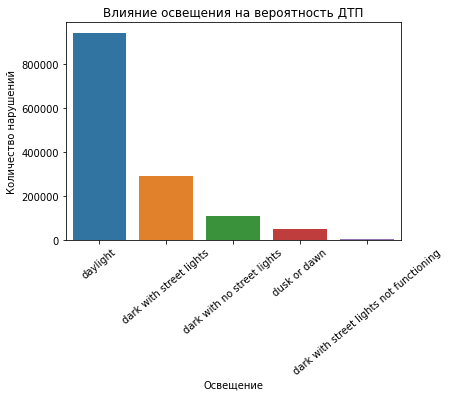

In [22]:
sns.barplot(data = lighting_damage, x='lighting', y='count_collisions')
plt.title('Влияние освещения на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Освещение')
plt.ylabel('Количество нарушений')
plt.show()

Можно сделать вывод, что освещение не особо влияет на вероятность возникновения дтп, хотя при ночном освещении риск все же есть

### Вывод

- наибольшее количество аварий приходится на октябрь месяц
- чаще всего дтп происходят когда дорогая сухая,но так же можно увидеть что мокрая дорога может повлиять на вероятность возникновения ДТП
- ДТП чаще всего случаются на дорогах без повреждений. Однако, дороги с зоной строительства или ремонта так же увлечивают риск возникновения ДТП
- самой частой причиной аварий является нарушение пдд
- чаще всего дтп происходят в нормальную погоду, но все же наиболее высокий риск попасть в дтп в облачную погоду или в дождь
- самыми частыми нарушениями является привышение скорости. На втором месте находится неправильный поворот
-  освещение не особо влияет на вероятность возникновения дтп, хотя при ночном освещении риск все же есть

## Создайте модель для оценки водительского риска

**Подготовьте набор данных на основе первичного предположения заказчика**:
- Выберите тип виновника — только машина (car). **
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

Сразу добавим в таблицу только те факторы, которые могут влиять на вероятность дтп:

In [23]:
query = '''
with 
  p as(
        select distinct case_id,
               at_fault,
               party_type, 
               party_sobriety,
               party_drug_physical,
               cellphone_in_use
        from parties),
  c as (
        select distinct case_id,
               weather_1,
               road_surface,
               lighting,
               road_condition_1,
               collision_date,
               collision_damage,
               intersection,
               control_device
        from collisions),
  v as (
        select distinct case_id,
               vehicle_age
        from vehicles),
  c_i as (
          select distinct case_id
          from case_ids)
select p.party_type,
       p.at_fault,
       p.party_sobriety,
       p.party_drug_physical,
       c.road_surface,
       c.lighting,
       c.road_condition_1,
       v.vehicle_age,
       c.intersection,
       p.cellphone_in_use,
       c.control_device,
       c.weather_1
from c_i
join p on c_i.case_id = p.case_id
join c on c_i.case_id = c.case_id
join v on c_i.case_id = v.case_id
where party_type = 'car'
  and collision_date between '2012-01-01' and '2013-01-01'
  and collision_damage != 'scratch'
'''
df = pd.read_sql_query(query, con=engine)

In [24]:
df.head()

,party_type,at_fault,party_sobriety,party_drug_physical,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
0,car,0,had not been drinking,None,dry,daylight,other,2.0,1.0,0.0,none,cloudy
1,car,1,had not been drinking,None,dry,daylight,other,2.0,1.0,0.0,none,cloudy
2,car,0,had not been drinking,None,dry,daylight,normal,5.0,1.0,0.0,none,clear
3,car,1,had not been drinking,None,dry,daylight,normal,5.0,1.0,0.0,none,clear
4,car,0,had not been drinking,None,dry,daylight,normal,1.0,1.0,0.0,functioning,clear


Были отобраны факторы, которые могут влиять на вероятность ДТП:
- 'party_sobriety' - Уровень трезвости виновника (точно может влиять) Таблица parties
- 'party_drug_physical' - Состояние участника: физическое или с учётом принятых лекарств. Таблица parties
- 'cellphone_in_use' - Возможность говорить по громкой связи в машине или нет. Таблица parties
- 'weather_1' - Погода. Таблица collisions
- 'road_surface' - Состояние дороги. Таблица collisions
- 'lighting' - Освещение. Таблица collisions
- 'road_condition_1' - Дорожное состояние. Таблица collisions 
- 'intersections' - Является ли перекрестком. Таблица collisions
- control_device - Устройство управления. Таблица collisions

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101523 entries, 0 to 101522
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   party_type           101523 non-null  object 
 1   at_fault             101523 non-null  int64  
 2   party_sobriety       99951 non-null   object 
 3   party_drug_physical  8438 non-null    object 
 4   road_surface         100910 non-null  object 
 5   lighting             101245 non-null  object 
 6   road_condition_1     101073 non-null  object 
 7   vehicle_age          98622 non-null   float64
 8   intersection         101186 non-null  float64
 9   cellphone_in_use     91676 non-null   float64
 10  control_device       101124 non-null  object 
 11  weather_1            101215 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 9.3+ MB


In [26]:
df.isna().mean()

party_type             0.000000
at_fault               0.000000
party_sobriety         0.015484
party_drug_physical    0.916886
road_surface           0.006038
lighting               0.002738
road_condition_1       0.004432
vehicle_age            0.028575
intersection           0.003319
cellphone_in_use       0.096993
control_device         0.003930
weather_1              0.003034
dtype: float64

Столбец party_drug_physical мог бы быть полезен, но в нем отсутствует более 90% данных, поэтому особой ценности он не представляет, дропнем его:

In [27]:
df = df.drop('party_drug_physical', axis=1)
df.head()

,party_type,at_fault,party_sobriety,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
0,car,0,had not been drinking,dry,daylight,other,2.0,1.0,0.0,none,cloudy
1,car,1,had not been drinking,dry,daylight,other,2.0,1.0,0.0,none,cloudy
2,car,0,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,none,clear
3,car,1,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,none,clear
4,car,0,had not been drinking,dry,daylight,normal,1.0,1.0,0.0,functioning,clear


Небольшой % пропусков категориальных значений, дропнем их, так как это не повлияет на исследование

In [28]:
df = df.dropna(subset = ['control_device','party_sobriety','weather_1','road_surface','lighting','road_condition_1'])

In [29]:
df=df.fillna(df[{'vehicle_age','cellphone_in_use','intersection'}].median())

In [30]:
df.isna().mean()

party_type          0.0
at_fault            0.0
party_sobriety      0.0
road_surface        0.0
lighting            0.0
road_condition_1    0.0
vehicle_age         0.0
intersection        0.0
cellphone_in_use    0.0
control_device      0.0
weather_1           0.0
dtype: float64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98385 entries, 0 to 101522
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   party_type        98385 non-null  object 
 1   at_fault          98385 non-null  int64  
 2   party_sobriety    98385 non-null  object 
 3   road_surface      98385 non-null  object 
 4   lighting          98385 non-null  object 
 5   road_condition_1  98385 non-null  object 
 6   vehicle_age       98385 non-null  float64
 7   intersection      98385 non-null  float64
 8   cellphone_in_use  98385 non-null  float64
 9   control_device    98385 non-null  object 
 10  weather_1         98385 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 9.0+ MB


In [32]:
cat = df[['party_sobriety','road_surface','road_condition_1']]
cat.head()

,party_sobriety,road_surface,road_condition_1
0,had not been drinking,dry,other
1,had not been drinking,dry,other
2,had not been drinking,dry,normal
3,had not been drinking,dry,normal
4,had not been drinking,dry,normal


Закодируем данные:

In [33]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
feature_arr = ohe.fit_transform(cat[cat.columns])
feature_labels = ohe.get_feature_names(cat.columns)
df_ohe = pd.DataFrame(feature_arr, columns=feature_labels)

In [34]:
df_ohe.head()

,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
t = df[['at_fault']]
t.head()

,at_fault
0,0
1,1
2,0
3,1
4,0


In [36]:
data = pd.merge(df_ohe,t, left_index=True, right_index=True)

In [37]:
data.head()

,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,at_fault
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [38]:
data.isna().mean()

party_sobriety_had been drinking, impairment unknown     0.0
party_sobriety_had been drinking, not under influence    0.0
party_sobriety_had been drinking, under influence        0.0
party_sobriety_had not been drinking                     0.0
party_sobriety_impairment unknown                        0.0
party_sobriety_not applicable                            0.0
road_surface_dry                                         0.0
road_surface_slippery                                    0.0
road_surface_snowy                                       0.0
road_surface_wet                                         0.0
road_condition_1_construction                            0.0
road_condition_1_flooded                                 0.0
road_condition_1_holes                                   0.0
road_condition_1_loose material                          0.0
road_condition_1_normal                                  0.0
road_condition_1_obstruction                             0.0
road_condition_1_other  

Разделим на обучающие признаки и целевые:

In [39]:
features = data.drop(['at_fault'], axis=1)
target = data['at_fault']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, shuffle=True, random_state=42)

## Проведите анализ важности факторов ДТП

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов. Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок. В идеале, стоит задача найти оптимальный баланс между этими двумя метриками, поэтому в данной работе я буду использовать метрику F1

### Decision Tree Classifier

In [40]:
dt_params = {
    'max_depth': [8],
    'min_samples_split': [5], 
    'min_samples_leaf': [25],
    'class_weight':['balanced']
}

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=5),
                         dt_params, n_jobs=-1,cv = 5,scoring = 'f1')
dt_f1 = dt_gs.fit(features_train, target_train)

In [41]:
print('Оптимальные параметры: ',dt_f1.best_params_) 

Оптимальные параметры:  {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 25, 'min_samples_split': 5}


In [42]:
print(f'Лучший roc_auc на обучающей выборке: {dt_f1.score(features_train, target_train)}')
print(f'Лучший roc_auc на тестовой выборке: {dt_f1.score(features_test, target_test)}')

Лучший roc_auc на обучающей выборке: 0.6689521757229964
Лучший roc_auc на тестовой выборке: 0.6683129378624083


### Random Forest Classifier

In [43]:
rf_params = {
    'criterion':['entropy'],
    'n_estimators': [10],
    'max_depth': [2],
    'min_samples_leaf': [10],
    'class_weight':['balanced']
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=5),
                     rf_params, cv = 10, scoring = 'f1',
                     verbose=2)
rf_f1 = rf_gs.fit(features_train, target_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=10, n_estim

In [44]:
print('Оптимальные параметры: ', rf_f1.best_params_) 

Оптимальные параметры:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 10}


In [45]:
print(f'Лучший roc_auc на обучающей выборке: {rf_f1.score(features_train, target_train)}')
print(f'Лучший roc_auc на тестовой выборке: {rf_f1.score(features_test, target_test)}')

Лучший roc_auc на обучающей выборке: 0.666518923444387
Лучший roc_auc на тестовой выборке: 0.6663602265205559


### CatBoost

In [46]:
from catboost import CatBoostClassifier
import catboost

In [47]:
cb = CatBoostClassifier(loss_function="Logloss", iterations=70, eval_metric = 'F1')
cb_f1 = cb.fit(features_train, target_train, verbose=10) 

Learning rate set to 0.5
0:	learn: 0.6911490	total: 57ms	remaining: 3.93s
10:	learn: 0.6892764	total: 133ms	remaining: 713ms
20:	learn: 0.6890420	total: 196ms	remaining: 457ms
30:	learn: 0.6891914	total: 254ms	remaining: 319ms
40:	learn: 0.6891626	total: 309ms	remaining: 219ms
50:	learn: 0.6891634	total: 363ms	remaining: 135ms
60:	learn: 0.6891634	total: 434ms	remaining: 64ms
69:	learn: 0.6891922	total: 509ms	remaining: 0us


In [48]:
predicted_test_cb = cb_f1.predict(features_test)

In [49]:
print(f'Лучший roc_auc на обучающей выборке: {cb_f1.score(features_train, target_train)}')
print(f'Лучший roc_auc на тестовой выборке: {cb_f1.score(features_test, target_test)}')

Лучший roc_auc на обучающей выборке: 0.5307081935123042
Лучший roc_auc на тестовой выборке: 0.5303848573825504


### Выбор Модели

In [50]:
predictive_model_scores = pd.DataFrame(data=[('Decision Tree',dt_f1.score(features_train, target_train),dt_f1.score(features_test, target_test)), 
                                             ('Random Forest',rf_f1.score(features_train, target_train), rf_f1.score(features_test, target_test)),
                                            ('CatBoost',cb_f1.score(features_train, target_train),cb_f1.score(features_test, target_test))], 
                                       columns=['model', 'training_f1', 'testing_f1'])
predictive_model_scores

,model,training_f1,testing_f1
0,Decision Tree,0.668952,0.668313
1,Random Forest,0.666519,0.666360
2,CatBoost,0.530708,0.530385


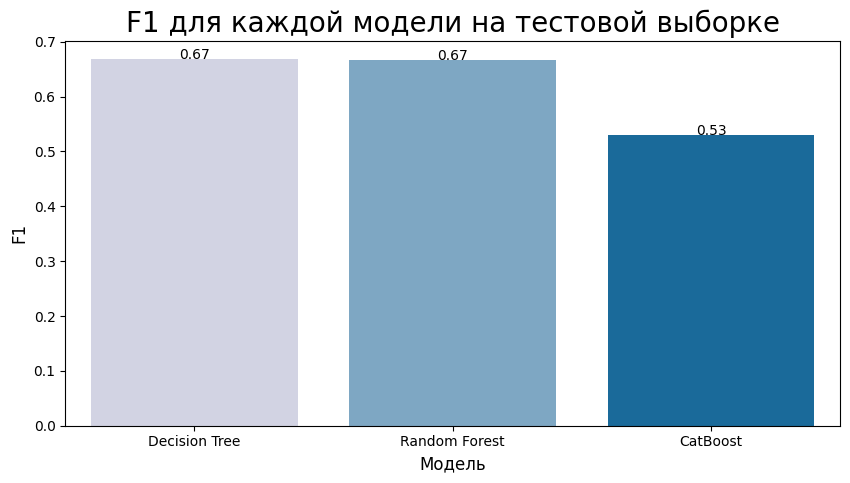

In [51]:
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_f1', data=predictive_model_scores, palette='PuBu')
plt.title('F1 для каждой модели на тестовой выборке', fontsize = 20)
plt.xlabel('Модель', fontsize = 12)
plt.ylabel('F1', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_f1, s=round(row.testing_f1,2), color='black', horizontalalignment='center');

Модели, обеспечивающие наивысший показатель точности тестирования, - это модели "Дерево решений" и "Случайный Лес".

### Confusion Matrix

In [52]:
predicted_test_dt = dt_f1.predict(features_test)
predicted_test_rf = rf_f1.predict(features_test)
predicted_test_cb = cb_f1.predict(features_test)

Создаём матрицы ошибок для каждой обученной модели:

In [53]:
cm_rf = confusion_matrix(target_test, predicted_test_rf)
cm_dt = confusion_matrix(target_test, predicted_test_dt)
cm_cb = confusion_matrix(target_test, predicted_test_cb)

In [54]:
cm_df_rf = pd.DataFrame(cm_rf, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

In [55]:
cm_df_dt = pd.DataFrame(cm_dt, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

In [56]:
cm_df_cb = pd.DataFrame(cm_cb, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

#### Визуализируем:

**Случайный лес**:

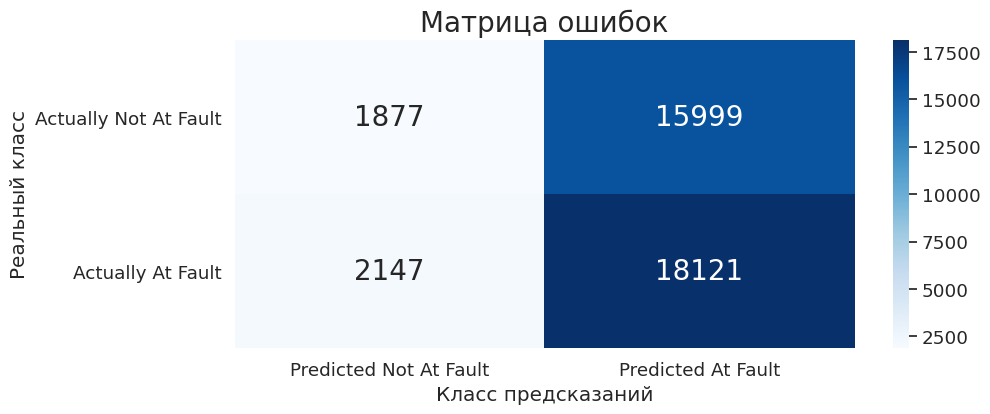

In [57]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_rf, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_rf.columns, yticklabels=cm_df_rf.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [58]:
TP = cm_rf[0][0]
TN = cm_rf[1][1]
FP = cm_rf[0][1]
FN = cm_rf[1][0]
total = cm_rf[0][0]+cm_rf[1][1]+cm_rf[0][1]+cm_rf[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 38144
Правильно классифицированные: 52.0%
Правильно классифицированная вина: 47.0%
Правильно классифицированое отсутствие вины: 53.0%
Прогнозируемая вина, соответствующая действительности: 11.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 89.0%


**Дерево решений**:

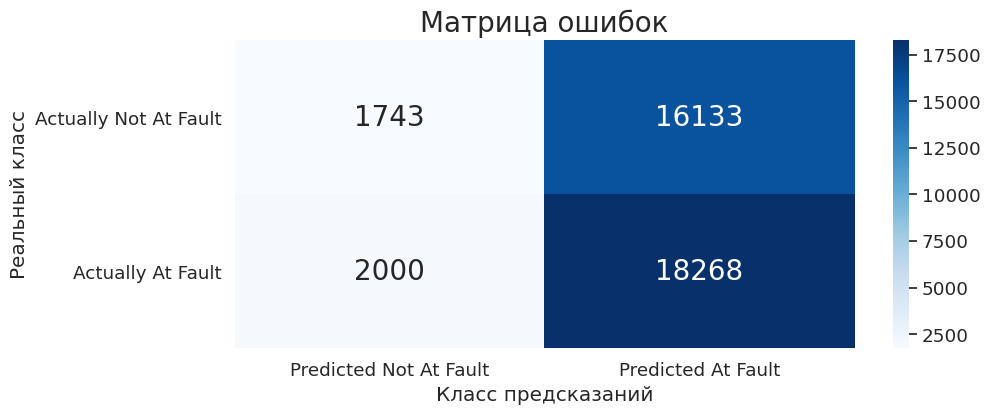

In [59]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_dt, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_dt.columns, yticklabels=cm_df_dt.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [60]:
TP = cm_dt[0][0]
TN = cm_dt[1][1]
FP = cm_dt[0][1]
FN = cm_dt[1][0]
total = cm_dt[0][0]+cm_dt[1][1]+cm_dt[0][1]+cm_dt[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 38144
Правильно классифицированные: 52.0%
Правильно классифицированная вина: 47.0%
Правильно классифицированое отсутствие вины: 53.0%
Прогнозируемая вина, соответствующая действительности: 10.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 90.0%


**CatBoost**:

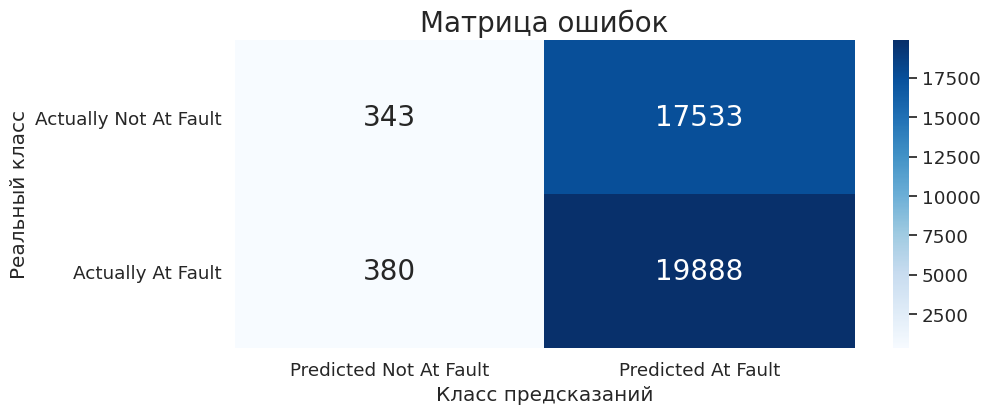

In [61]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_cb, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_cb.columns, yticklabels=cm_df_cb.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [62]:
TP = cm_cb[0][0]
TN = cm_cb[1][1]
FP = cm_cb[0][1]
FN = cm_cb[1][0]
total = cm_cb[0][0]+cm_cb[1][1]+cm_cb[0][1]+cm_cb[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 38144
Правильно классифицированные: 53.0%
Правильно классифицированная вина: 47.0%
Правильно классифицированое отсутствие вины: 53.0%
Прогнозируемая вина, соответствующая действительности: 2.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 98.0%


#### Feature Importances

**Decision Tree**:

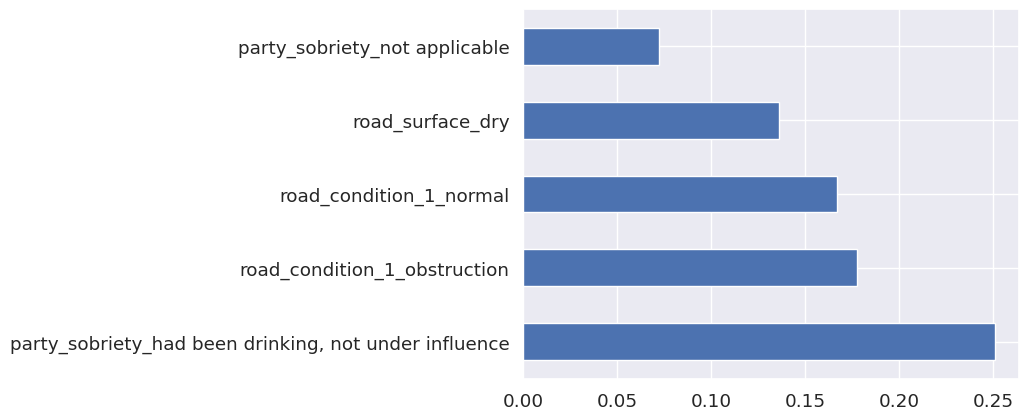

In [63]:
feat_importances_dt = pd.Series((dt_gs.best_estimator_.feature_importances_), index=features.columns)
feat_importances_dt.nlargest(5).plot(kind='barh')
plt.show()

Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, не под влиянием"

Для графического анализа будем использовать столбчатую диаграмму. В ней отразим зависимость числа ДТП от уровня трезвости.

In [64]:
query = '''
select distinct party_sobriety,
       count(case_id) count_party_sobriety
from parties
where party_sobriety != 'had not been drinking'
   and party_sobriety != 'not applicable'
group by party_sobriety
order by count_party_sobriety desc
'''
party_sobriety = pd.read_sql_query(query, con=engine)
party_sobriety

,party_sobriety,count_party_sobriety
0,impairment unknown,232901
1,"had been drinking, under influence",112413
2,"had been drinking, impairment unknown",21419
3,"had been drinking, not under influence",17650


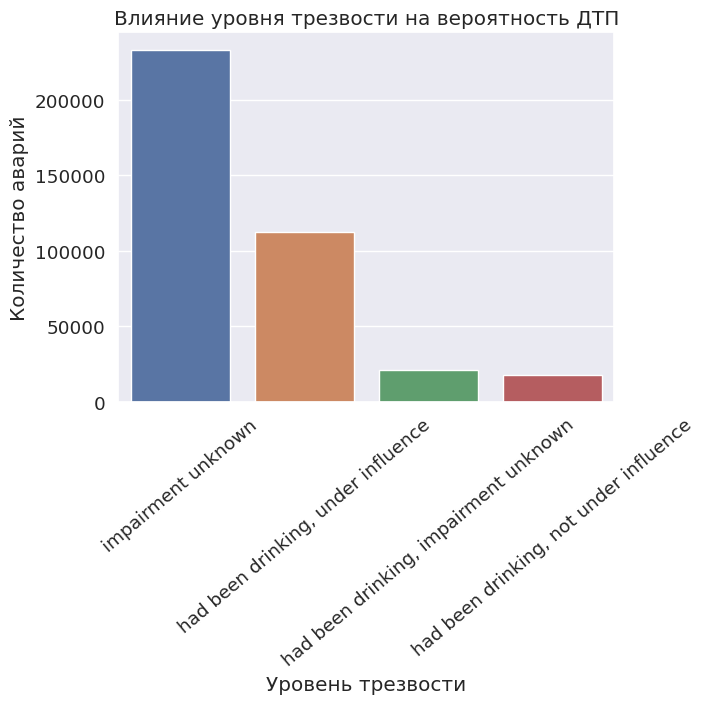

In [65]:
import seaborn as sns
sns.barplot(data = party_sobriety, x='party_sobriety', y='count_party_sobriety')
plt.title('Влияние уровня трезвости на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Уровень трезвости')
plt.ylabel('Количество аварий')
plt.show()

### Вывод

- Случайный Лес:
  - F1 на тестовой выборке = 0.6663
  - Всего предсказаний: 38144
  - Правильно классифицированные: 52.0%
  - Правильно классифицированная вина: 47.0%
  - Правильно классифицированое отсутствие вины: 53.0%
  - Прогнозируемая вина, соответствующая действительности: 11.0%
  - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 89.0%
- Дерево решений:
  - F1 на тестовой выбрке = 0.6683
  - Всего предсказаний: 38144
  - Правильно классифицированные: 52.0%
  - Правильно классифицированная вина: 47.0%
  - Правильно классифицированое отсутствие вины: 53.0%
  - Прогнозируемая вина, соответствующая действительности: 10.0%
  - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 90.0%
- Catboost:
  - F1 на тестовой выборке = 0.5303
  - Всего предсказаний: 38144
  - Правильно классифицированные: 53.0%
  - Правильно классифицированная вина: 47.0%
  - Правильно классифицированое отсутствие вины: 53.0%
  - Прогнозируемая вина, соответствующая действительности: 2.0%
  - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 98.0%
  
**Исходя из полученных данных, можно сделать вывод, что наилучшей моделью является модель "Дерево решений"**. 



## Выводы

**Исходя из полученных данных, можно сделать вывод, что наилучшей моделью является модель "Дерево решений"**:
  - F1 на тестовой выбрке = 0.6683
  - Всего предсказаний: 38144
  - Правильно классифицированные: 52.0%
  - Правильно классифицированная вина: 47.0%
  - Правильно классифицированое отсутствие вины: 53.0%
  - Прогнозируемая вина, соответствующая действительности: 10.0%
  - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 90.0%
  - Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, не под влиянием". 
  
**Так как самый важный фактор ДТП — уровень трезвости виновника (party_sobriety), то можно**:
   - оборудовать автомобиль анализатором алкогольного опьянения
   - измерение состояния при посадке сделать обязательным условием допуска за руль, без этого машина не заведется
   - чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место
   - чтобы убедиться, что в трубку дышит именно водитель, добавить отпечаток пальца или face id на водительском месте

  


